Epoch 10/80, Loss: 0.2275, Accuracy: 0.7267
Epoch 20/80, Loss: 0.1813, Accuracy: 0.7812
Epoch 30/80, Loss: 0.1402, Accuracy: 0.8256
Epoch 40/80, Loss: 0.1142, Accuracy: 0.8617
Epoch 50/80, Loss: 0.0995, Accuracy: 0.8743
Epoch 60/80, Loss: 0.0896, Accuracy: 0.8910
Epoch 70/80, Loss: 0.0821, Accuracy: 0.9053
Epoch 80/80, Loss: 0.0758, Accuracy: 0.9145


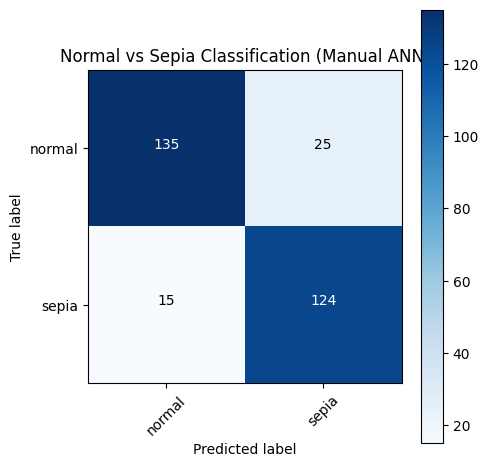

Accuracy: 0.8662207357859532
Precision: 0.8322147651006712
Recall: 0.8920863309352518


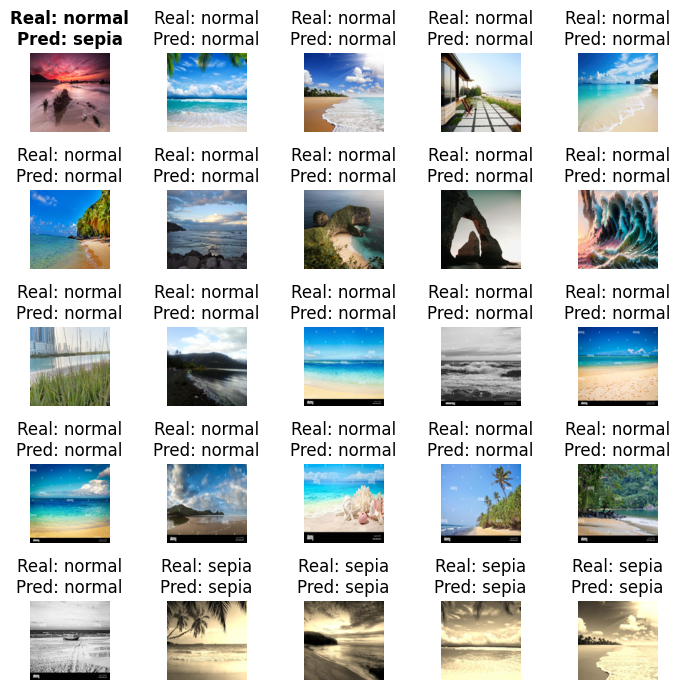

In [10]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

# Data loading and preprocessing functions
def loadImageData(base_path, categories, target_size=(128, 128)):
    inputs = []
    outputs = []
    output_names = ['normal', 'sepia']
    for category in categories:
        normal_folder = os.path.join(base_path, 'Normal_ImageData', category)
        for img_name in os.listdir(normal_folder):
            img_path = os.path.join(normal_folder, img_name)
            img = Image.open(img_path).resize(target_size).convert('RGB')
            inputs.append(np.array(img).flatten())
            outputs.append(0)
        sepia_folder = os.path.join(base_path, 'Sepia_ImageData', category)
        for img_name in os.listdir(sepia_folder):
            img_path = os.path.join(sepia_folder, img_name)
            img = Image.open(img_path).resize(target_size).convert('RGB')
            inputs.append(np.array(img).flatten())
            outputs.append(1)
    return np.array(inputs), np.array(outputs), output_names

def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = list(range(len(inputs)))
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    testSample = [i for i in indexes if i not in trainSample]
    return (np.array([inputs[i] for i in trainSample]),
            np.array([outputs[i] for i in trainSample]),
            np.array([inputs[i] for i in testSample]),
            np.array([outputs[i] for i in testSample]))

def normalisation(trainData, testData):
    scaler = StandardScaler()
    scaler.fit(trainData)
    return scaler.transform(trainData), scaler.transform(testData)

class ManualANN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        np.random.seed(1) 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # initialize weights and biases with random values scaled by sqrt(1/input_size)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

# compunte the hidden and ouptut layer predicitons
    def forward(self, X):
        
        hidden = self.relu(np.dot(X, self.W1) + self.b1)
        #computes thr linear transfrormarion then goves a1 the hidden layer activation
        
        output = self.sigmoid(np.dot(hidden, self.W2) + self.b2)
        return output

    def train_step(self, X, y):
        
        m = X.shape[0]
        y = y.reshape(-1, 1)
        
        # forward pass 
        hidden = self.relu(np.dot(X, self.W1) + self.b1)
        output = self.sigmoid(np.dot(hidden, self.W2) + self.b2)
        
        # compute gradients of loss (backward)
        error = output - y  #the difference between predicted and the output
        ### incearca cros entropeie
        # the gradients for the output layers
        dW2 = np.dot(hidden.T, error) / m
        db2 = np.sum(error, axis=0, keepdims=True) / m
        #backprop to hidden layers
        error_hidden = np.dot(error, self.W2.T) * (hidden > 0).astype(float)
        #gradients for hidden layer
        dW1 = np.dot(X.T, error_hidden) / m
        db1 = np.sum(error_hidden, axis=0, keepdims=True) / m
        
        # update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        
        # return loss for monitoring
        return np.mean((y - output) ** 2)

    def fit(self, X, y, max_iter=80, verbose=2):
        for epoch in range(max_iter):
            loss = self.train_step(X, y)
            if verbose > 1 and (epoch + 1) % 10 == 0:
                output = self.forward(X)
                predictions = (output >= 0.5).astype(int).flatten()
                accuracy = np.mean(predictions == y)
                print(f'Epoch {epoch + 1}/{max_iter}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    def predict(self, X):
        output = self.forward(X)
        return (output >= 0.5).astype(int).flatten()

# evaluation and plotting functions
def evalMultiClass(true_labels, predicted_labels, output_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    prec, recall, _, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    return acc, prec, recall, cm

def plotConfusionMatrix(cm, output_names, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(output_names))
    plt.xticks(tick_marks, output_names, rotation=45)
    plt.yticks(tick_marks, output_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", 
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# main execution
categories = ['Beaches', 'Countryside', 'Deserts', 'Fields', 'Forests', 'Lakes', 'Mountains', 'Sunset', 'Urban']
base_path = 'C:/Users/LENOVO/PycharmProjects/AI/LAB7/DataBase'
inputs, outputs, output_names = loadImageData(base_path, categories)
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)
trainInputsNormalised, testInputsNormalised = normalisation(trainInputs, testInputs)

# test the model and evaluate performanc
input_size = trainInputsNormalised.shape[1]
hidden_size = 15  
output_size = 1
classifier = ManualANN(input_size, hidden_size, output_size, learning_rate=0.01)
classifier.fit(trainInputsNormalised, trainOutputs, max_iter=80, verbose=2)

predictedLabels = classifier.predict(testInputsNormalised)

acc, prec, recall, cm = evalMultiClass(testOutputs, predictedLabels, output_names)
plotConfusionMatrix(cm, output_names, "Normal vs Sepia Classification (Manual ANN)")
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', recall)

n, m = 5, 5
fig, axes = plt.subplots(n, m, figsize=(7, 7))
fig.tight_layout()
for i in range(n):
    for j in range(m):
        idx = m * i + j
        if idx < len(testInputs):
            img = testInputs[idx].reshape(128, 128, 3)
            img = np.clip(img, 0, 255).astype(np.uint8)
            axes[i][j].imshow(img)
            font = 'normal' if testOutputs[idx] == predictedLabels[idx] else 'bold'
            axes[i][j].set_title(f'Real: {output_names[testOutputs[idx]]}\nPred: {output_names[predictedLabels[idx]]}', fontweight=font)
            axes[i][j].set_axis_off()
plt.show()